# Overview

Below is my approach to estimating the average year's temperature in Texas (or any state) based on noisy measurements of temperature data.

I model each station's (indexed by $j$) average temperature as a draw from a Normal distribution with mean $m$ and variance $s^2$. That is,

$$\mu_j \sim \text{N}(m, s^2).$$

Since I want a single "population" average temperature, I ultimately want to infer the unknown $m$. I assign an informative prior to $m$, reflecting the fact that the temperature (in Celcius) is most likely in the interval $20 \pm 10$. On how widely the station averages vary $s^2$, I assigned a flat prior with infinite variance reflecting my uncertainty. Mathematically,

$$m \sim \text{N}(20, 10^2)$$
$$s^2 \sim \text{Inv-Gamma}(1.1, 1).$$

I then model each data point, a single measurement at a specific time, as having been generated from a Normal distribution with that station's mean and variance.

$$x_{i,j} \sim \text{N}(\mu_j, \sigma^2_j).$$

This basic structure forms a hierarchical Bayesian model, which I simplify slightly in order to apply Gibbs and Metropolis-Hastings algorithms to generate MCMC samples from the posterior $P(m,s^2 | X)$.

In [2]:
import os
import pandas as pd

if not os.path.exists("data"):
    os.makedirs("data")

# Download and Prepare the Data

Get all stations within year range.

In [3]:
first_year, last_year = 2005, 2017

import utilities
stations = utilities.get_stations("TX", first_year, last_year)

In [4]:
stations[:5], len(stations)

(['720965-13910',
  '722323-99999',
  '722410-12917',
  '722416-12971',
  '722420-12923'],
 61)

Now I'll download the files within the range using a helper function in module *utilities.py*. Not all of the stations listed at ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.txt, which has the beginning and end date of the data collection for each station, exist in the ISD Lite dataset, so I'll skip those files. 

This is a challenge that my inference will have to account for (I'll assume they're missing for reasons uncorrelated with temperature).

In [ ]:
utilities.download_files(stations, first_year, last_year)

In [5]:
data_list = []
for yr in range(first_year, last_year + 1):
    for station in stations:
        try:
            df = pd.read_table("data/" + station + "-" + str(yr) + ".gz", na_values = ["-9999"],
                       compression = "gzip",
                       header = None, 
                       sep = r"\s+")
            df["station"] = station
            data_list.append(df)
        except:
            continue

Need to concatinate data, rename columns, scale variables, and merge year, day, month, hour columns into a single variable. Current state of each table:

In [6]:
data_list[0].head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,station
0,2005,1,6,5,10.0,0.0,NaN,10,31,8.0,NaN,NaN,722323-99999
1,2005,2,23,18,180.0,160.0,NaN,0,0,8.0,NaN,NaN,722323-99999
2,2005,2,24,12,80.0,80.0,NaN,360,51,8.0,NaN,NaN,722323-99999
3,2005,3,20,0,NaN,NaN,10203.0,240,36,NaN,NaN,NaN,722323-99999
4,2005,3,21,15,190.0,170.0,NaN,180,51,4.0,NaN,NaN,722323-99999


In [7]:
df = pd.concat(data_list, ignore_index=True)
df = df[[0, 1, 2, 3, 4, "station"]]

Now I just rename the remaining columns, scale the temperature variable back to its natural scale, convert to datetime, and save the data.

In [8]:
df = df.rename(columns={0:"year", 1:"month", 2:"day", 3:"hour", 4:"air_temp"})
df["air_temp"] = df["air_temp"]/10
df["timestamp"] = pd.to_datetime(df[["year", "month", "day", "hour"]])
df.drop(["year", "month", "day", "hour"], axis = 1, inplace = True)

inds = list(range(-1, -3, -1)) + list(range(0, (df.shape[1] - 2)))
df = df.iloc[:, inds]

In [9]:
df = df.dropna()

df.to_pickle("data/pandas_data")

# Exploring the data

In [10]:
frame = pd.read_pickle("data/pandas_data")

In [11]:
agg_year_trend = frame.groupby(frame.timestamp.dt.year).mean().reset_index()

print(agg_year_trend)

    timestamp   air_temp
0        2005  21.163849
1        2006  20.573648
2        2007  19.371603
3        2008  19.775870
4        2009  20.020503
5        2010  19.391111
6        2011  20.806881
7        2012  20.917556
8        2013  18.516241
9        2014  18.465119
10       2015  18.679354
11       2016  19.805367
12       2017  19.997645


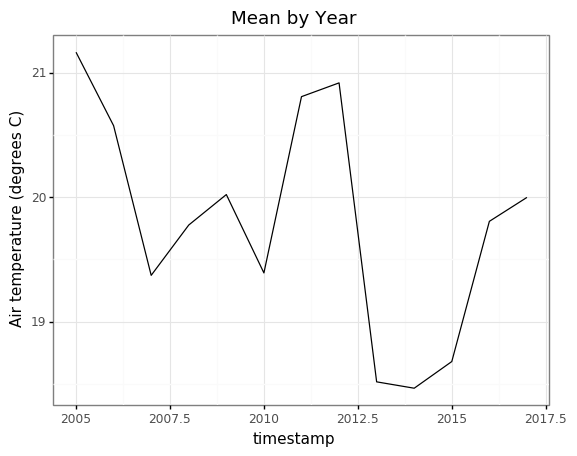

<ggplot: (328366130)>

In [12]:
from plotnine import *

ggplot(aes(x = "timestamp", y = "air_temp"), data = agg_year_trend) +\
    geom_line() +\
    labs(y = "Air temperature (degrees C)", title = "Mean by Year") +\
    theme_bw()

There are a few problems with this plot, obviously. Next attempt might be to average averages:

In [13]:
station_year_trend = frame.groupby([frame.timestamp.dt.year, frame.station]).mean().reset_index()
station_year_trend.head(5)

,timestamp,station,air_temp
0,2005,722323-99999,16.781562
1,2005,722410-12917,20.732727
2,2005,722416-12971,20.664624
3,2005,722420-12923,22.231037
4,2005,722430-12960,20.994828


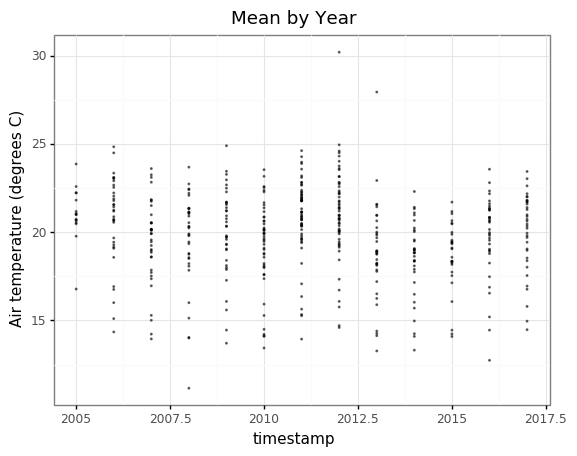

<ggplot: (-9223372036526343052)>

In [14]:
ggplot(aes(x = "timestamp", y = "air_temp"), data = station_year_trend) +\
    geom_point(size = 0.2, alpha = 0.5) +\
    labs(y = "Air temperature (degrees C)", title = "Mean by Year") +\
    theme_bw()

Above plot is overplotted and we can't see the trend.

Trends for the subset of stations that were recorded for 12+ years:

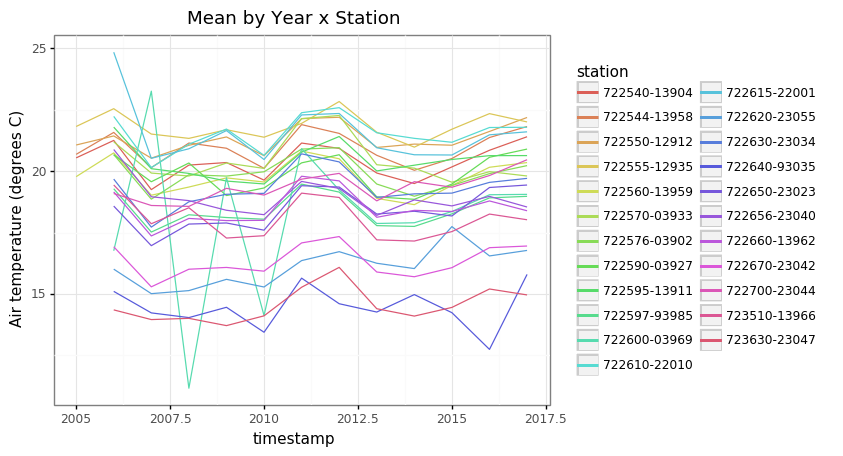

<ggplot: (332806390)>

In [15]:
stations12 = station_year_trend['station'].value_counts().index[station_year_trend['station'].value_counts() >= 12].tolist()
stations12_ind = station_year_trend['station'].map(lambda x : x in stations12)
ggplot(aes(x = "timestamp", y = "air_temp", color = "station"), data = station_year_trend.loc[stations12_ind, ]) +\
    geom_line() +\
    labs(y = "Air temperature (degrees C)", title = "Mean by Year x Station") +\
    theme_bw()

Note a couple things:

1. Same trend +/- a constant.
2. Some stations more volatile than others, should be trusted less. Possible source of variability:
        - Measurement practices such as inconsistent time of day, year; i.e. large sigma
        - Fewer collected observations

Although points 1 and 2 suggest that this average will have good frequentist/asymptotic properties, it seems inadequate because of (2). Ideally we'd weight the observations associated with more "variable" stations less.

Additionally, asymptotics don't make much practical sense: we can't redo last decade's data collection.

Below is the plot of the average-of-averages by year, overlaid with the previous approach which used a global average:

In [16]:
station_year_trend.groupby("timestamp").mean()
agg_year_trend2 = station_year_trend.groupby("timestamp").mean().reset_index()

In [17]:
agg_year_trend["method"] = "grand mean"
agg_year_trend2["method"] = "mean of means"

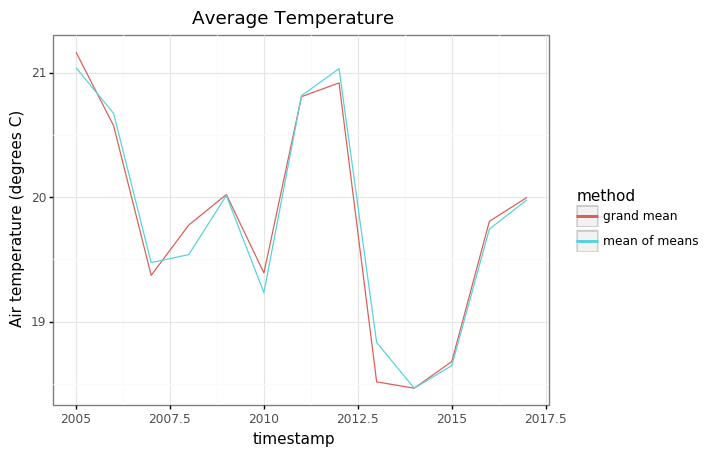

<ggplot: (-9223372036507303266)>

In [18]:
ggplot(aes(x = "timestamp", y = "air_temp", color = "method"), data = pd.concat([agg_year_trend, agg_year_trend2])) +\
    geom_line() +\
    labs(y = "Air temperature (degrees C)", title = "Average Temperature") +\
    theme_bw()

We desire a model that, for each year, can correctly weight the averages from each station, accounting for each group's variability and sample size. The result should be a compromise between taking the grand mean of all data points and taking an average of averages.

# The Model

Considering inference for any year $k$, (but suppressing it from here on out) we'll model each datapoint $x_{i,j} \sim \text{N}(\mu_j, \sigma^2_j)$, where $j$ indexes each station, and $i$ represents each of the year's (year $k$'s) datapoints. The parameters $\mu_j,\sigma^2_j$ are unique to each station.

One may treat $\sigma_j$ and $\mu_j$ as unknown, with each being drawn from an unknown distribution shared between all stations $j$. This would be a complete hierarchical model  On first pass, we may have,

$$\mu_j \sim \text{N}(m, s^2)$$
$$\sigma_j \sim \text{Gamma}(\alpha,\beta)$$.

The priors over the hyperparameters $m,s,\alpha,\beta$ may be modeled by
$$m \sim \text{N}(20, 10^2)$$
$$s^2 \sim \text{Inv-Gamma}(1.1, 1)$$
$$\alpha \sim \text{Gamma}(10^{-3}, 10^{-3})$$
$$\beta \sim \text{Gamma}(10^{-3}, 10^{-3})$$

Then each observation is drawn from its corresponding (it's station's) distribution:
$$
x_{i,j} \sim \text{N}(\mu_j, \sigma^2_j)
$$

At this point it is desirable to simplify the model.

First, our original goal was to determine the "population" mean over all of the stations in Texas, for each year. Mathematically, this corresponds to the expectation of the hyper-posterior $m$, given the all of the data: $\text{E}[m | X]$. Doing accurate inference on each $\sigma_s$ is only worthwhile if the standard errors over each $\sigma_j$ are large.

To substantially simplify the algorithm and allow for shortcuts, it is desirable to treat $\sigma_j$ as if it is known, which is two simplifications away from the "ideal" hierarchical Bayesian model that one may expect. Below, I've computed a very crude estimate of the standard deviation of $\sigma_j$ for each station for each year.

In [19]:
summary = frame.groupby(["station", frame.timestamp.dt.year]).agg(["var", "count"]).reset_index()
summary["std error of sigma_{jk}"] = (((summary['air_temp']['var']**2)/(summary['air_temp']['count']))**(1/2))
summary.head(10)

station timestamp    air_temp       std error of sigma_{jk}
                                  var count                        
0  720965-13910      2015  108.258513  8526                1.172437
1  722323-99999      2005   74.408191  1703                1.803073
2  722323-99999      2011  102.781655  7701                1.171230
3  722323-99999      2012   83.795837  8376                0.915596
4  722410-12917      2005   61.558462  8739                0.658502
5  722410-12917      2011   72.326391  8757                0.772893
6  722410-12917      2012   47.182931  8780                0.503544
7  722416-12971      2005   72.793706  8746                0.778375
8  722416-12971      2011   95.859185  8739                1.025423
9  722416-12971      2012   65.406587  8752                0.699146

Inspecting this DataFrame I find some NaNs, corresponding to stations with zero observations for that year. These are noted and safely ignored.

In [20]:
summary["std error of sigma_{jk}"].describe()

count    485.000000
mean       0.958634
std        0.499841
min        0.107340
25%        0.736943
50%        0.920493
75%        1.105784
max        7.533525
Name: std error of sigma_{jk}, dtype: float64

Keeping in mind my goal of inference on $m$ (uncertainty in $\sigma_j$ is relatively unimportant), and because the standard error is small relative to the magnitude, for the sake of computational/implementation simplicity, I'll use point estimates for $\sigma_j$ rather than modeling it hierarchically. Call it $\hat{\sigma}_j$ and treat it as a deterministic function of the data. This leaves the following model:

$$x_{i,j} \sim \text{N}(\mu_j, \hat{\sigma}^2_j(x_{\cdot j}))$$

$$\mu_j \sim \text{N}(m, s^2)$$

$$m \sim \text{N}(20, 10^2)$$
$$s^2 \sim \text{Inv-Gamma}(1.1, 1)$$

(From now on, I'll use the LHS of $\hat{\sigma}^2_j=\hat{\sigma}^2_j(x_{\cdot j})$.)

In principle, it suffices to plug in $X$ and sample from the unnormalized posterior below via an MCMC method, and ignore the $s$ and $\mu_s$:

$$
P(m,s,\mu_j | X) \propto \Pi_j \Pi_i P(x_{i,j} | \mu_j, \hat{\sigma}_j) P(\mu_j | m,s) P(m) P(s)
$$

However because I am limiting myself to inference on $m$, and took liberties using $\hat{\sigma}_s$, it is highly beneficial to marginalize out each $\mu_j$, reducing the dimensionality of the posterior from 63 to 2 dimensions:

\begin{align}
\int_{\mu} P(m,s,\mu_j | X) &\propto \Pi_j \left( \int_{\mu_j} \Pi_i P(x_{i,j} | \mu_j, \hat{\sigma}_j P(\mu_j | m,s) d\,\mu_j \right) P(m) P(s)
\end{align}

But after attempting the integral, I realize I can reparameterize in terms of sufficient statistics $\bar{x}_j$ and $n_j$, the mean of the $j$th station and the number of observations of that group. From basic statistics, we know that $\bar{x}_j \sim \text{N}(\mu_j, \hat{\sigma}_j^2/n_j)$.

Therefore, I use:

$$\bar{x}_j \sim \text{N}(\mu_j, \hat{\sigma}_j^2/n_j)$$

$$\mu_j \sim \text{N}(m, s^2)$$

$$m \sim \text{N}(20, 10^2)$$
$$s^2 \sim \text{Inv-Gamma}(1.1, 1)$$

and I need

\begin{align}
\int_{\mu} P(m,s^2,\mu_j | X) &\propto \Pi_j \left( \int_{\mu_j} P\left(\bar{x}_j | \mu_j, \hat{\sigma}_j\right) P(\mu_j | m,s^2) d\,\mu_j \right) P(m) P(s^2).
\end{align}

It's apparent that the term in parenthesis is the normalization constant for Bayesian inference on the mean with prior $m,s$. This leaves

\begin{align}
\int_{\mu} P(m,s^2,\mu_j | X) &\propto \Pi_j P(\bar{x}_j | m,s^2) P(m) P(s^2).
\end{align}

where
$$\bar{x}_j | m,s^2\sim \text{N}\left(m, \frac{\hat{\sigma}_j^2}{n_j} + s^2 \right).$$
All the terms on the right are now analytic, so I just need to apply an MCMC technique to sample values of $(s^2,m)$.

Note: This problem simplified itself substantially. In practical applications I'd evaluate the density with vectorized functions over a discrete grid and normalize. That would be highly preferable to a Markov Chain in Python. As a coding exhibition, I'll use more powerful methods. The other option also allows me to easily diagnose problems with the MCMC functions.

# Implementation

Because we only have two dimensions, it's worthwhile to inspect the forms of the conditionals to see if Gibbs sampling can be implemented efficiently. If the conditionals can't be sampled from directly, I'd use multivariate Metropolis-Hastings.

Holding $s^2$ fixed, both components of the unnormalized joint density that contain $m$ are exponentials of a quadratic in $m$. This is good news (and expected). The algebra shows that this Gibbs update is

$$
m_{t + 1} \sim \text{N}\left(v^2\left[20/10^2 + \sum_j \bar{x}_j/(\hat{\sigma}_j^2 + s_{t}^2)\right], v^2\right)
$$

where the variance 
$$
v^2 = \left[ 1/10^2 + \sum_j 1/(\hat{\sigma}_j^2 + s_{t}^2) \right]^{-1}
$$

(dependent on the prior sample $s^2_t$)

Holding $m$ fixed and inspecting $s^2$, we have

$$
\propto \frac{1}{s}\exp\left(-\frac{(x - m)^2}{2\left(\frac{\hat{\sigma}_j^2}{n_j} + s^2\right)}\right) 
(s^2)^{-1.1 - 1}\exp\left(-\frac{1}{s^2}\right)
$$

which isn't a recognizable distribution that I can directly sample from (and if it were, I would have marginalized it out). Instead, I'll alternate Gibbs updates for $m$ with Metropolis-Hastings updates for $s^2$.

This illustrates the fact that Gibbs sampling is no different from the Metropolis-Hastings algorithm where the proposal distribution is the variable's conditional distribution (and intermediate samples are thinned to de-correlate).



# Summarizing the Data

I'll leave this section open to analyze each station's measurements more thoroughly (if time allows) and consider other ways to summarize each station's measurements. Update: in the interest of time, I chose not to worry about the small irregularities in frequencies of measurements at each station. There were a few reasons:

1. Irregularity of measurements should be reflected in the variance of each year's measurements, which the model is designed to handle.

2. The vast majority of stations across the majority of years chosen recorded temperatures on the hour, every hour. Deviations are hard to find and are minor.

3. I couldn't come up with inclusion/exclusion criteria that don't seem arbitrary (e.g. how many days/hours without measurements should disqualify the station?)

# Results

In [2]:
import pandas as pd
import numpy as np
from plotnine import *
frame = pd.read_pickle('data/pandas_data')

Using the same dataframe, I'll aggregate to get the sufficient statistics and collect them into a Series of 2-tuples each containing an array of station means. 

In [3]:
aggs = frame.groupby([frame.timestamp.dt.year, "station"]).agg(["var", "count", "mean"]).reset_index()
aggs.columns = aggs.columns.droplevel()
aggs.columns = ['year', 'station', 'var', 'count', 'mean']
aggs['var_mean'] = aggs['var']/aggs['count']

data_list = []

for yr in aggs.year.unique():
    yr_data = aggs[aggs['year'] == yr]
    data_list.append((np.array(yr_data['mean']), np.array(yr_data['var_mean'])))
data_ser = pd.Series(data_list, index = aggs.year.unique())

In [4]:
import mcmc
from importlib import reload
reload(mcmc)


<module 'mcmc' from '/Users/josephmiller/Desktop/NOAA_ISD_Data/mcmc.py'>

In [5]:
#%%pixie_debugger
m, s2 = mcmc.gen_samples(data_ser[2006][0], data_ser[2006][1], 20, 5, burn_in=5000, iters = 20000, propose_sigma = 3, hyper_alpha = 1.1, hyper_beta = 1)

In [6]:
samples = pd.DataFrame([np.arange(len(m)), m, s2]).T
samples.columns = ["iter", "m", "s2"]

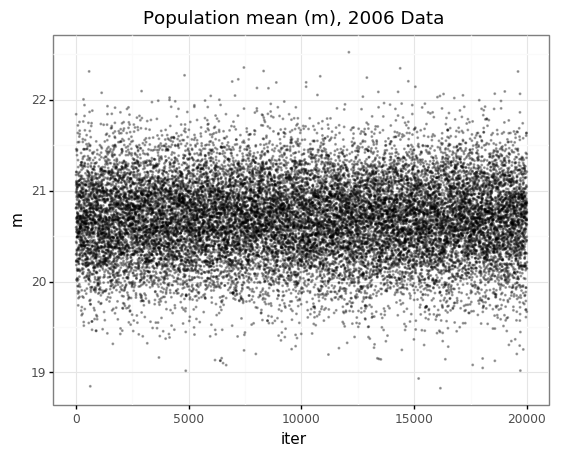

<ggplot: (-9223372036574887445)>

In [7]:
ggplot(aes(x = "iter", y = "m"), data = samples) + geom_point(size = 0.2, alpha = 0.3) + theme_bw() + labs(title = "Population mean (m), 2006 Data")

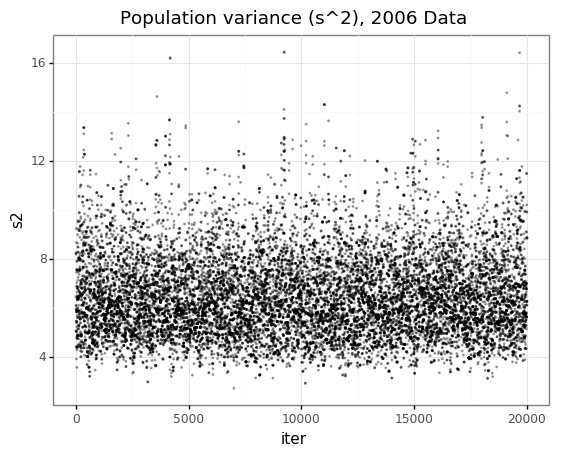

<ggplot: (-9223372036572168907)>

In [15]:
ggplot(aes(x = "iter", y = "s2"), data = samples) + geom_point(size = 0.2, alpha = 0.3) + theme_bw() + labs(title = "Population variance (s^2), 2006 Data")

These plots look good. The prior on $s^2$ $(\alpha = 1.1, \beta = 1)$ has fat tails: a mean of 10 and an infinite variance, but the posterior is clearly more reasonable and reflects the data well.

I tuned the sampler so about half of the candidate values of $s^2$ are rejected.

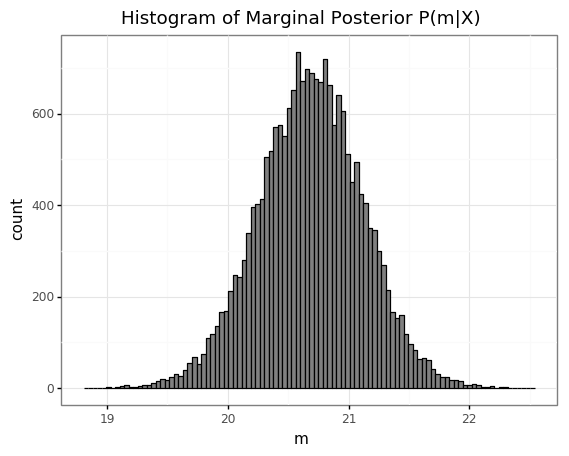

<ggplot: (282869277)>

In [20]:
ggplot(data = pd.DataFrame({"m": m})) + geom_histogram(aes(x = "m"), color = "black", fill = "grey", bins = 100) + theme_bw() + labs(title = "Histogram of Marginal Posterior P(m|X)")

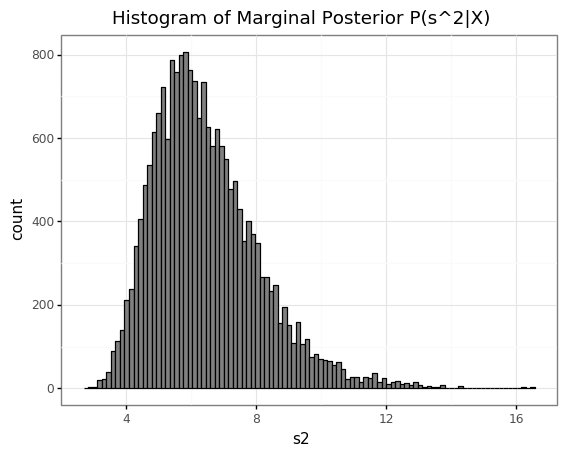

<ggplot: (282590756)>

In [22]:
ggplot(data = pd.DataFrame({"s2": s2})) + geom_histogram(aes(x = "s2"), color = "black", fill = "grey", bins = 100) + theme_bw() + labs(title = "Histogram of Marginal Posterior P(s^2|X)")

In [9]:
len(np.unique(s2))/len(s2)

0.4853

Summary of $m|X$

In [1]:
pd.Series(m).describe()

NameError: name 'pd' is not defined

Summary of $s^2 | X$:

In [30]:
pd.Series(s2).describe()

count    20000.000000
mean         6.421672
std          1.595310
min          2.819188
25%          5.310743
50%          6.205418
75%          7.289369
max         17.428340
dtype: float64

## Population Means for Each Year

In [31]:
samples = []
for yr in data_ser.index:
    m, s2 = mcmc.gen_samples(data_ser[yr][0], data_ser[yr][1], 20, 5, burn_in=5000, iters = 20000, propose_sigma = 3, hyper_alpha = 1.1, hyper_beta = 1)
    samples.append((m, s2))

samples = pd.Series(samples, index = data_ser.index)

In [32]:
agg_year_trend3 = pd.DataFrame({"air_temp" : np.array(samples.apply(lambda x: np.mean(x[0]))), "timestamp" : samples.index, "method" : "hierarchical bayes"})

In [38]:
final = pd.concat([agg_year_trend, agg_year_trend2, agg_year_trend3], sort = True)

Both reassuring and disappointing: we find that the hierarchical Bayesian approach I carried out leads to almost identical point estimates as the mean-of-means approach. Because the data set is large, this isn't too surprising. 

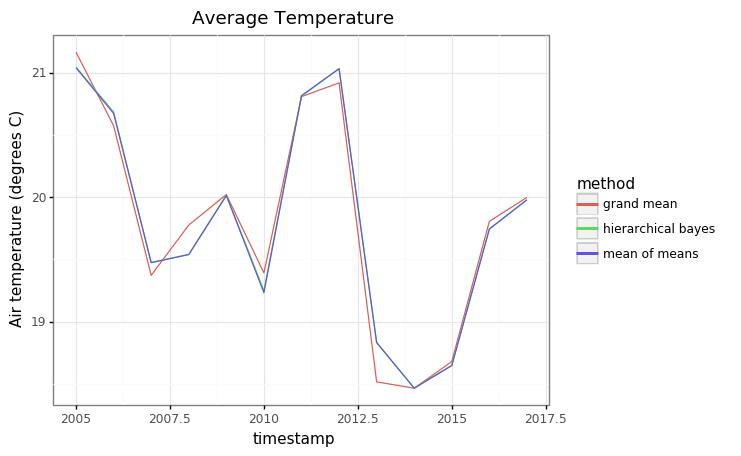

<ggplot: (-9223372036507281015)>

In [34]:
ggplot() +\
    geom_line(aes(x = "timestamp", y = "air_temp", color = "method"), data = final) +\
    labs(y = "Air temperature (degrees C)", title = "Average Temperature") +\
    theme_bw()

In [35]:
agg_year_trend3

,air_temp,timestamp,method
0,21.044260,2005,hierarchical bayes
1,20.684882,2006,hierarchical bayes
2,19.475292,2007,hierarchical bayes
3,19.540299,2008,hierarchical bayes
4,20.015000,2009,hierarchical bayes
5,19.249978,2010,hierarchical bayes
6,20.810912,2011,hierarchical bayes
7,21.030714,2012,hierarchical bayes
8,18.830414,2013,hierarchical bayes
9,18.465975,2014,hierarchical bayes


In [36]:
upper = samples.apply(lambda x: np.percentile(x[0], 97.5))
lower = samples.apply(lambda x: np.percentile(x[0], 2.5))
agg_year_trend3['upper'] = np.array(upper)
agg_year_trend3['lower'] = np.array(lower)

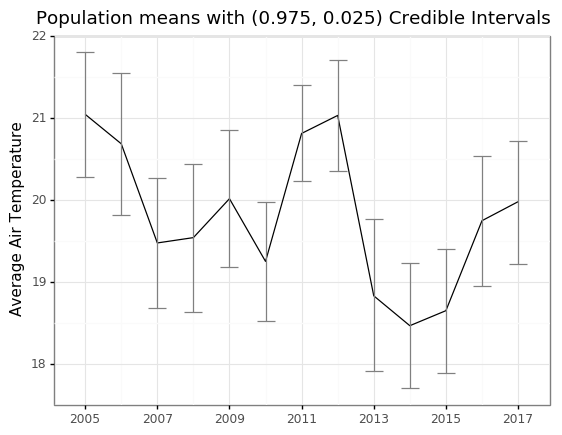

<ggplot: (-9223372036521960311)>

In [37]:
ggplot(aes(x = "timestamp", y = "air_temp", ymin = "lower", ymax = "upper"), data = agg_year_trend3) +\
geom_line()  +\
geom_errorbar(color = "grey") +\
theme_bw() +\
scale_x_continuous(breaks = np.arange(2005, 2018, 2)) +\
labs(title = "Population means with (0.975, 0.025) Credible Intervals", x = "", y = "Average Air Temperature")

# Note on Tests

tests.py contains some tests to help me debug the code. They can be run with pytest.

In the last two tests, I used the simplification where the $\bar{x}_j$'s variance is zero, leaving only variance from the population, $s^2$. This allowed me to analytically simplify the results and compare to known distributions, or easily compute the solution over a grid.